In [25]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras import optimizers

import time 

### Data Processing

In [2]:
df = pd.read_csv('../data/num_data.csv')

In [3]:
dataset = df[:1000]

In [4]:
dataset.shape

(1000, 16)

In [5]:
# Useful functions
def plot_predictions(test, predicted):
    plt.figure(figsize=(30, 15));

    plt.plot(test, color='red', alpha=0.5, label='Actual PM2.5 Concentration',)
    plt.plot(predicted, color='blue', alpha=0.5, label='Predicted PM2.5 Concentation')
    plt.title('PM2.5 Concentration Prediction')
    plt.xlabel('Time')
    plt.ylabel('PM2.5  Concentration')
    plt.legend()
    plt.show()
    

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse

In [6]:
data_size = dataset.shape[0]
train_size=int(data_size * 0.6)
test_size = 100
valid_size = data_size - train_size - test_size

test_next_day = [12, 24, 48]

In [7]:
training_set = dataset[:train_size].iloc[:,4:16].values
valid_set = dataset[train_size:train_size+valid_size].iloc[:,4:16].values
test_set = dataset[data_size-test_size:].iloc[:,4:16].values

In [8]:
y = dataset.iloc[:,4].values
y = y.reshape(-1,1)

y.shape

(1000, 1)

In [9]:
# Scaling the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
valid_set_scaled = sc.fit_transform(valid_set)
test_set_scaled = sc.fit_transform(test_set)

sc_y = MinMaxScaler(feature_range=(0,1))
y_scaled = sc_y.fit_transform(y)

In [55]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
X_train = []
y_train = []
seq_len = 24 # the length of timesteps in time-series analysis
for i in range(seq_len, train_size):
    X_train.append(training_set_scaled[i-seq_len:i,:])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
X_valid = []
y_valid = []

for i in range(seq_len, valid_size):
    X_valid.append(valid_set_scaled[i-seq_len:i,:])
    y_valid.append(valid_set_scaled[i,0])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

In [12]:
X_test = []
y_test = []

for i in range(seq_len, test_size):
    X_test.append(test_set_scaled[i-seq_len:i,:])
    y_test.append(test_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [13]:
X_valid.shape

(276, 24, 12)

In [14]:
y_train.shape

(576,)

In [56]:
DFS = Sequential()
CBGRU = Sequential()

DFS_GRU = Sequential()
CBLSTM = Sequential()

DFS_2LSTM = Sequential()
CB_2GRU = Sequential()


# filters defines how many features will be captured
# kernel size gives the size of the sliding window
DFS.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
DFS.add(MaxPooling1D(pool_size=4))
DFS.add(Dropout(0.2))  
DFS.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1],12), activation='tanh'))
DFS.add(Dropout(0.190 + 0.0025 * seq_len))
DFS.add(Dense(units=n_steps_out))

CBGRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
CBGRU.add(MaxPooling1D(pool_size=4))
CBGRU.add(Dropout(0.2))  
CBGRU.add(Bidirectional(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1],12), activation='tanh')))
CBGRU.add(Dense(units=n_steps_out))


DFS_GRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
DFS_GRU.add(MaxPooling1D(pool_size=4))
DFS_GRU.add(Dropout(0.2))  
DFS_GRU.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1],12), activation='tanh'))
DFS_GRU.add(Dropout(0.190 + 0.0025 * seq_len))
DFS_GRU.add(Dense(units=n_steps_out))

CB_LSTM.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
CB_LSTM.add(MaxPooling1D(pool_size=4))
CB_LSTM.add(Dropout(0.2))  
CB_LSTM.add(Bidirectional(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1],12), activation='tanh')))
CB_LSTM.add(Dense(units=n_steps_out))


DFS_2LSTM.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
DFS_2LSTM.add(MaxPooling1D(pool_size=4))
DFS_2LSTM.add(Dropout(0.2))  
DFS_2LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],12), activation='tanh'))
DFS_2LSTM.add(LSTM(units=50,  activation='tanh'))
DFS_2LSTM.add(Dropout(0.190 + 0.0025 * seq_len))
DFS_2LSTM.add(Dense(units=n_steps_out))

CB_2GRU.add(Conv1D(filters=64, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1],12)))
CB_2GRU.add(MaxPooling1D(pool_size=4))
CB_2GRU.add(Dropout(0.2))  
CB_2GRU.add(Bidirectional(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],12), activation='tanh')))
CB_2GRU.add(Bidirectional(GRU(units=50, activation='tanh')))
CB_2GRU.add(Dense(units=n_steps_out))



# Compiling the RNNs
adam = optimizers.Adam(lr=0.01)

DFS.compile(optimizer=adam,loss='mean_squared_error')
CBGRU.compile(optimizer=adam,loss='mean_squared_error')

NameError: name 'n_steps_out' is not defined

In [52]:
RnnModelDict = {'LSTM': LSTM_reg, 'GRU': GRU_reg, 'LSTM_LSTM': LSTM_LSTM_reg, 'GRU_GRU': GRU_GRU_reg, 
                'LSTM_GRU': LSTM_GRU_reg, 'GRU_LSTM': GRU_LSTM_reg}

X_test_12 = X_test[:12]
y_test_12 = y_test[:12]
X_test_24 = X_test[:24]
y_test_24 = y_test[:24]
X_test_48 = X_test[:48]
y_test_48 = y_test[:48]

rmse_df = pd.DataFrame(columns=['Model', 'train_rmse', 'valid_rmse', '24h_pred_rmse', 'train_time'])

RnnModelDict = {'DFS': DFS, 'CBGRU': CBGRU}

training start for DFS
Epoch 1/50
576/576 [==============================] - 2s 3ms/step - loss: 0.0762
Epoch 2/50
576/576 [==============================] - 0s 203us/step - loss: 0.0334
Epoch 3/50
576/576 [==============================] - 0s 178us/step - loss: 0.0248
Epoch 4/50
576/576 [==============================] - 0s 177us/step - loss: 0.0203
Epoch 5/50
576/576 [==============================] - 0s 173us/step - loss: 0.0212
Epoch 6/50
576/576 [==============================] - 0s 174us/step - loss: 0.0194
Epoch 7/50
576/576 [==============================] - 0s 169us/step - loss: 0.0169
Epoch 8/50
576/576 [==============================] - 0s 175us/step - loss: 0.0157
Epoch 9/50
576/576 [==============================] - 0s 174us/step - loss: 0.0164
Epoch 10/50
576/576 [==============================] - 0s 231us/step - loss: 0.0144
Epoch 11/50
576/576 [==============================] - 0s 215us/step - loss: 0.0151
Epoch 12/50
576/576 [==============================] - 0s 191us/

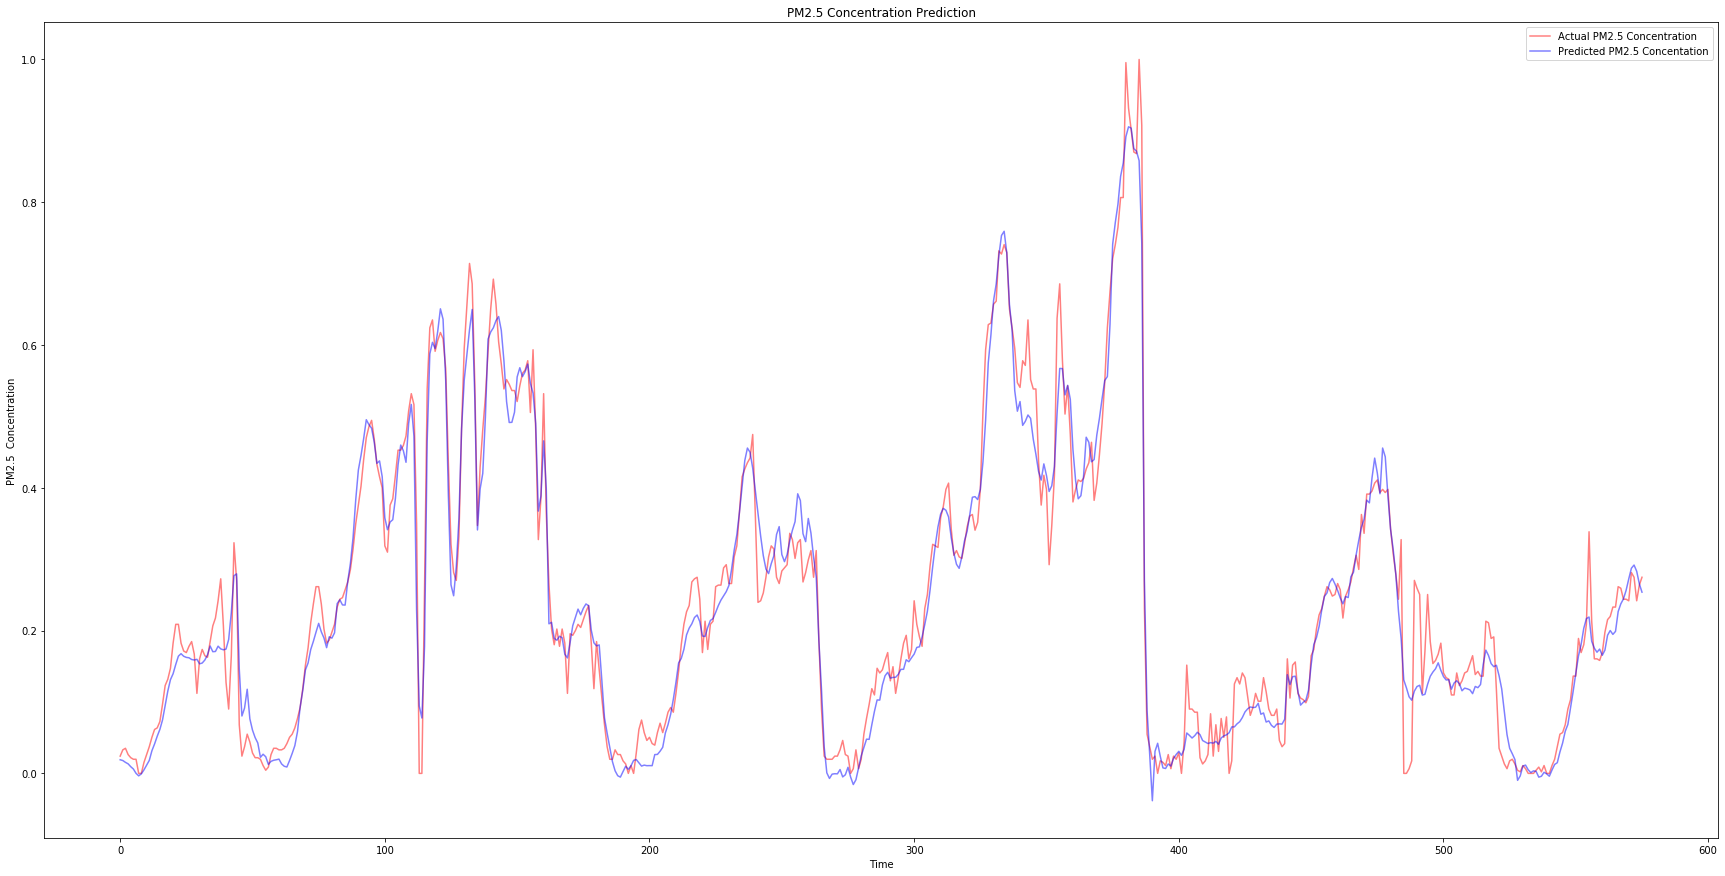

results for valid set


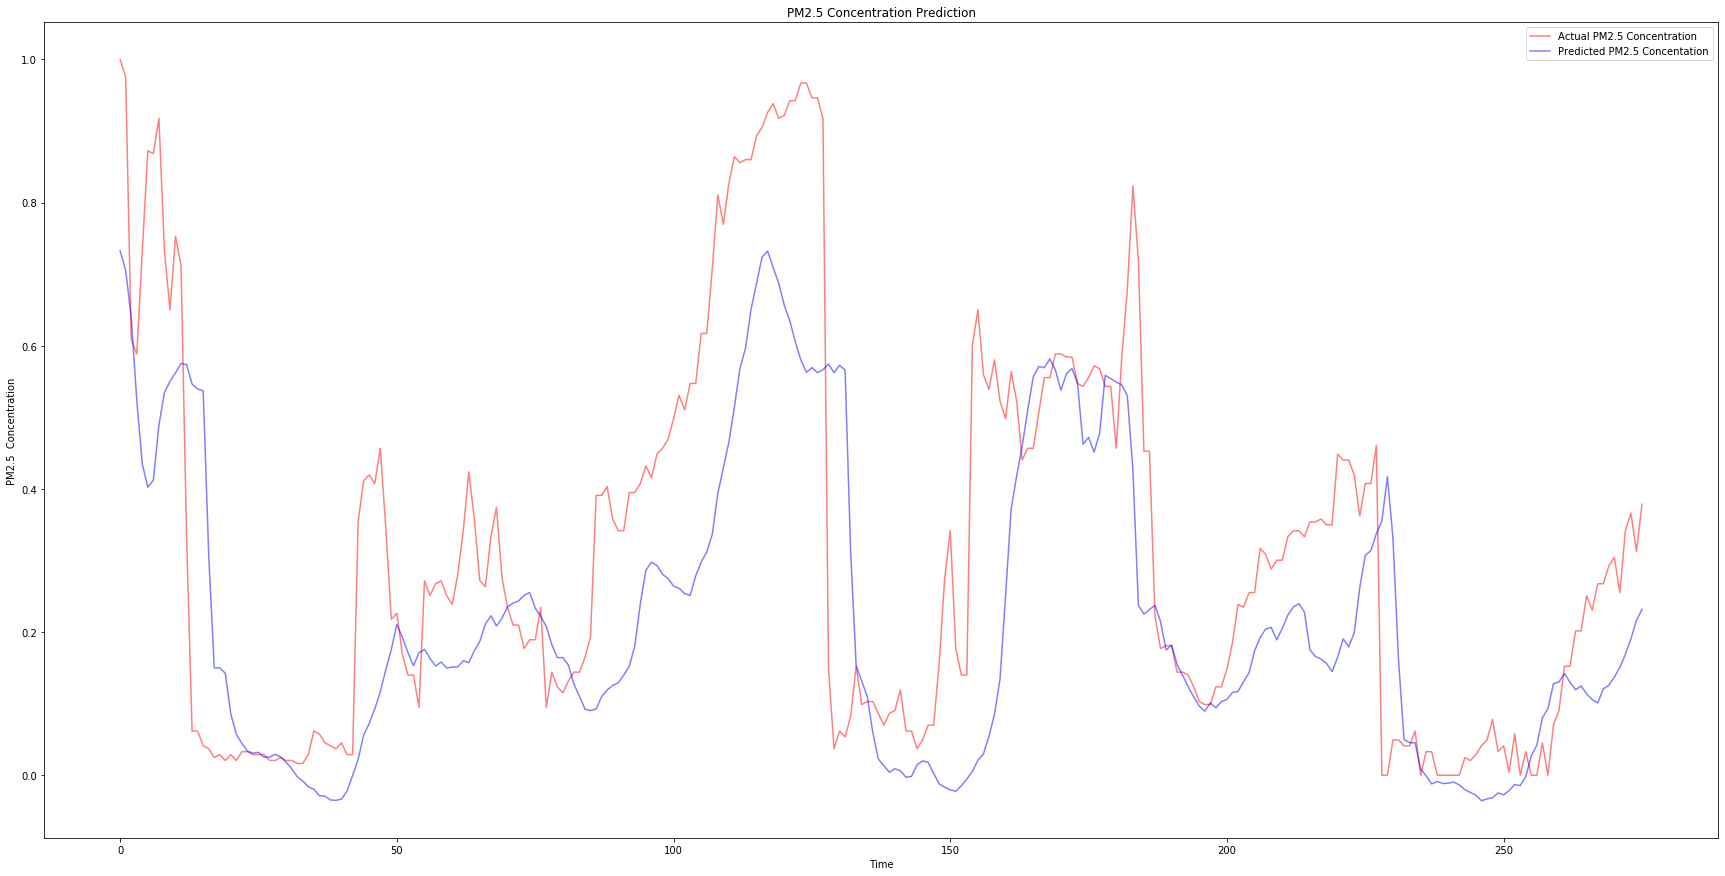

results for test set - 24 hours


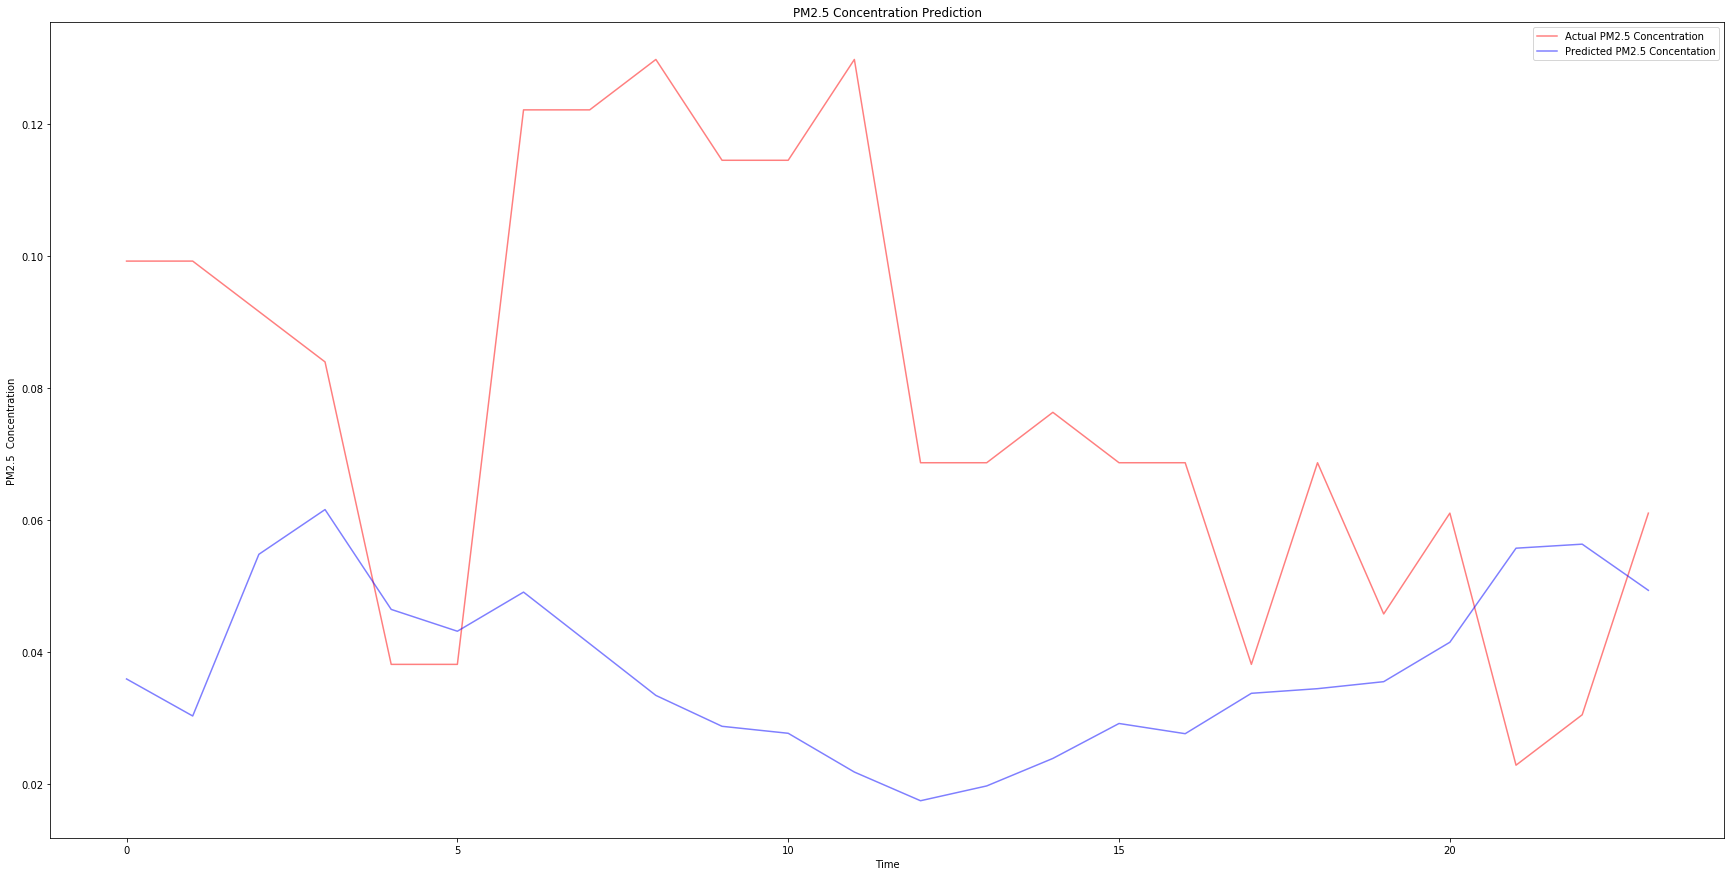

training start for CBGRU
Epoch 1/50
576/576 [==============================] - 3s 5ms/step - loss: 5.4356
Epoch 2/50
576/576 [==============================] - 0s 230us/step - loss: 0.0624
Epoch 3/50
576/576 [==============================] - 0s 280us/step - loss: 0.0455
Epoch 4/50
576/576 [==============================] - 0s 292us/step - loss: 0.0428
Epoch 5/50
576/576 [==============================] - 0s 268us/step - loss: 0.0449
Epoch 6/50
576/576 [==============================] - 0s 265us/step - loss: 0.0434
Epoch 7/50
576/576 [==============================] - 0s 260us/step - loss: 0.0433
Epoch 8/50
576/576 [==============================] - 0s 312us/step - loss: 0.0422
Epoch 9/50
576/576 [==============================] - 0s 257us/step - loss: 0.0414
Epoch 10/50
576/576 [==============================] - 0s 216us/step - loss: 0.0417
Epoch 11/50
576/576 [==============================] - 0s 213us/step - loss: 0.0414
Epoch 12/50
576/576 [==============================] - 0s 214u

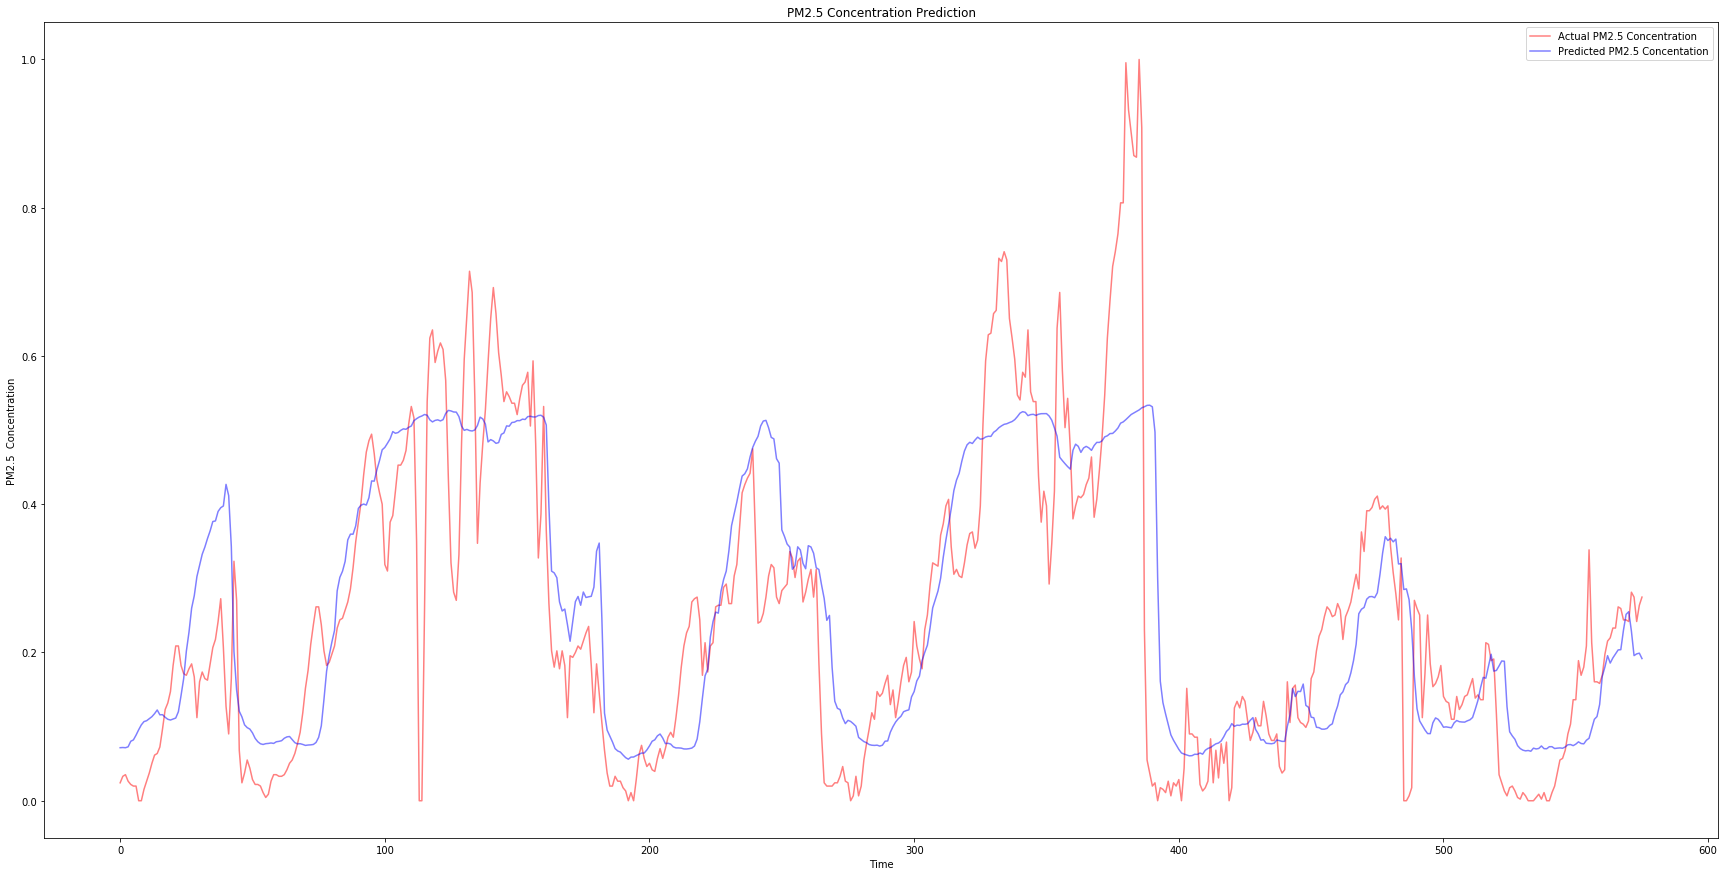

results for valid set


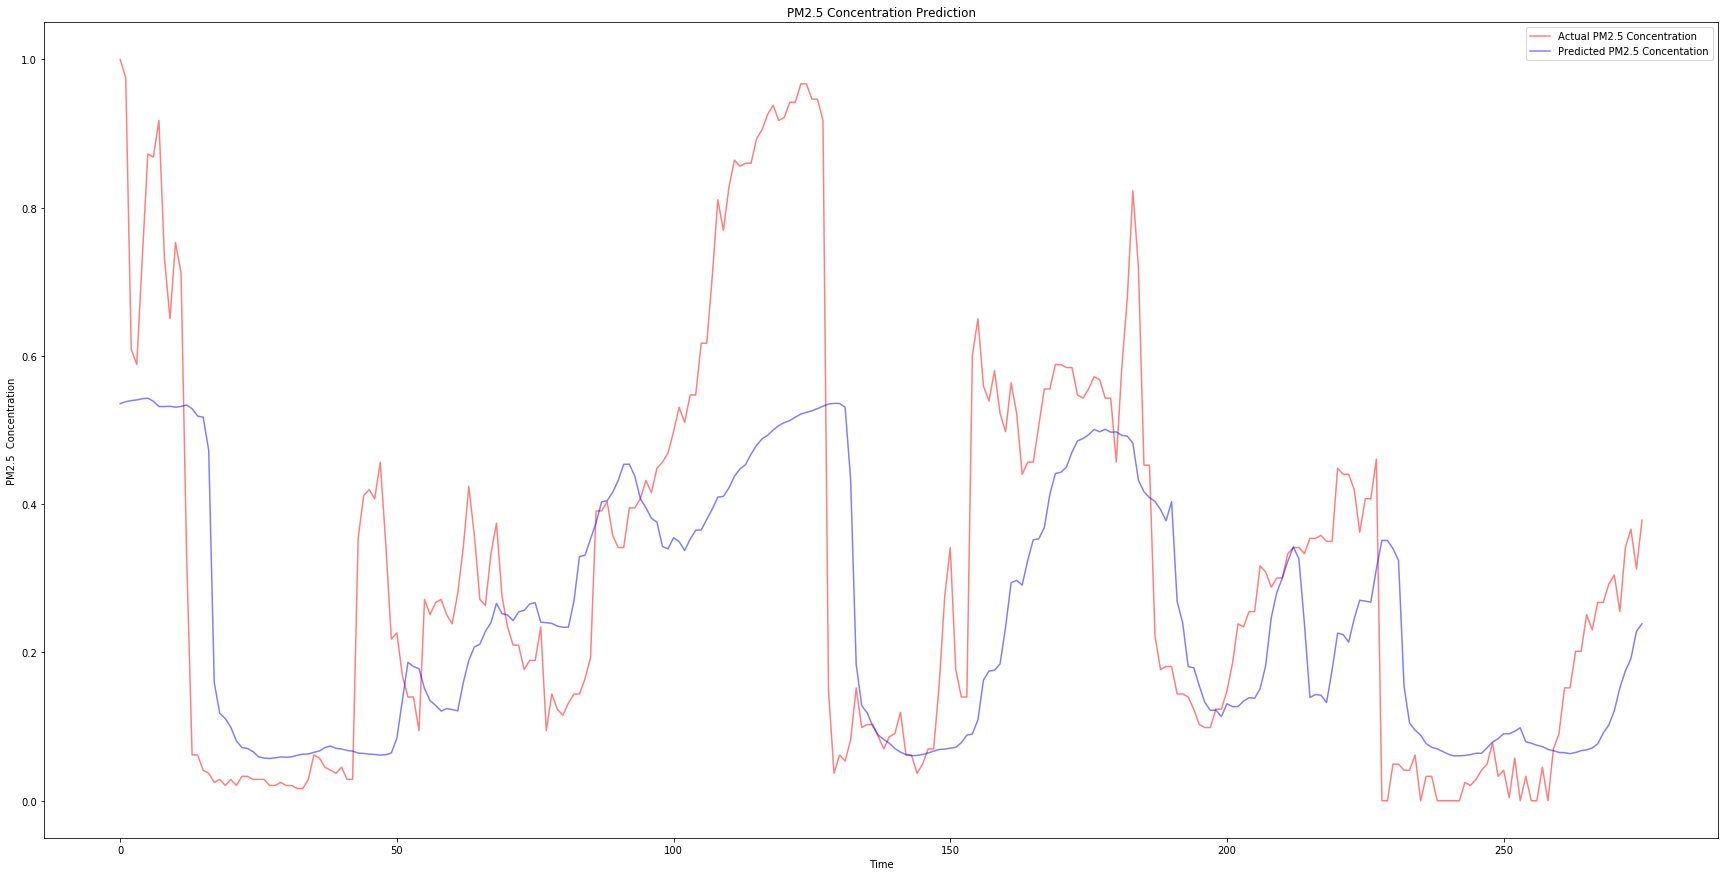

results for test set - 24 hours


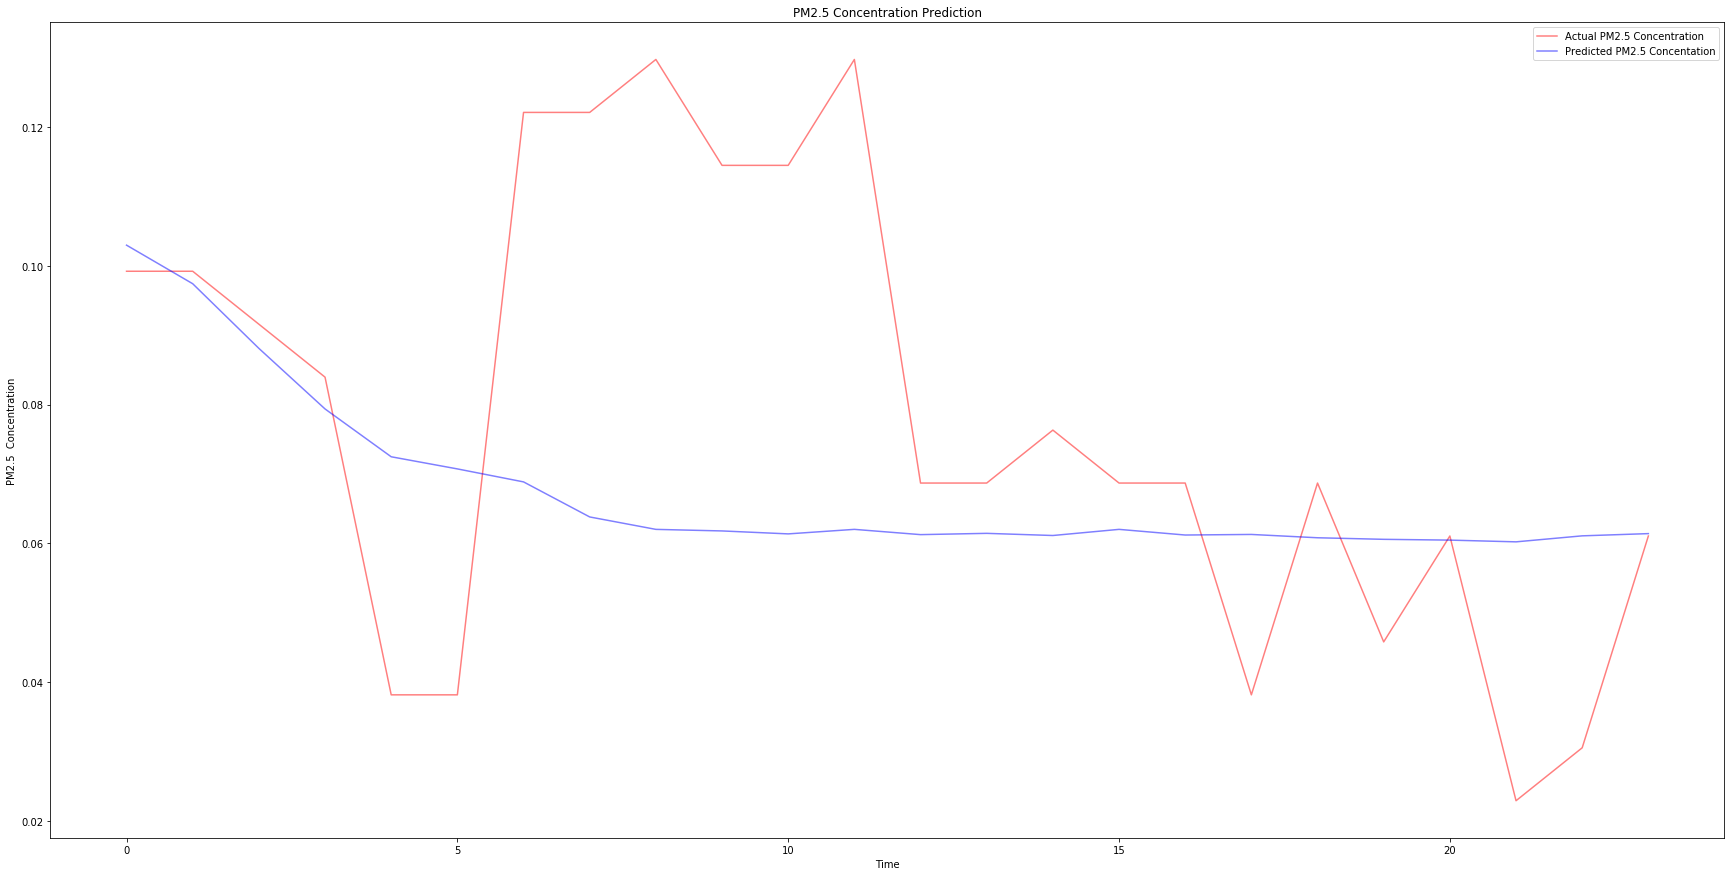

In [53]:
for model in RnnModelDict:
    regressor = RnnModelDict[model]
    
    print('training start for', model)    
    start = time.process_time()
    regressor.fit(X_train,y_train,epochs=50,batch_size=32)
    train_time = round(time.process_time() - start, 2)
    
    print('results for training set')
    y_train_pred = regressor.predict(X_train)
    plot_predictions(y_train,y_train_pred)
    train_rmse = return_rmse(y_train,y_train_pred)
    
    print('results for valid set')
    y_valid_pred = regressor.predict(X_valid)
    plot_predictions(y_valid,y_valid_pred)
    valid_rmse = return_rmse(y_valid,y_valid_pred)
    
    
    print('results for test set - 24 hours')
    y_test_pred24 = regressor.predict(X_test_24)
    plot_predictions(y_test_24,y_test_pred24)
    test24_rmse = return_rmse(y_test_24,y_test_pred24)
    
    
    one_df = pd.DataFrame([[model, train_rmse, valid_rmse, test24_rmse, train_time]], 
                          columns=['Model', 'train_rmse', 'valid_rmse', '24h_pred_rmse', 'train_time'])
    rmse_df = pd.concat([rmse_df, one_df])

# save the rmse results 
rmse_df.to_csv('../rmse_result_v2.csv')




In [394]:
X_valid[0,:,1]

array([0.62889518, 0.54390935, 0.57507082, 0.65439093, 0.5694051 ,
       0.41359773, 0.39093484, 0.41076487, 0.54107649, 0.70254958,
       0.78186969, 0.8101983 , 0.68838527, 0.69971671, 0.67988669,
       0.7223796 , 0.74220963, 0.72804533, 0.78186969, 0.78186969,
       0.94617564, 1.        , 0.898017  , 0.98866856])

In [395]:
y_valid[0]

1.0

In [370]:
y_train_origin = y_train.reshape(-1, 1)
y_train_origin = sc_y.inverse_transform(y_train_origin)


In [371]:
y_train_pred = regressor.predict(X_train)
y_train_pred_origin = sc_y.inverse_transform(y_train_pred)


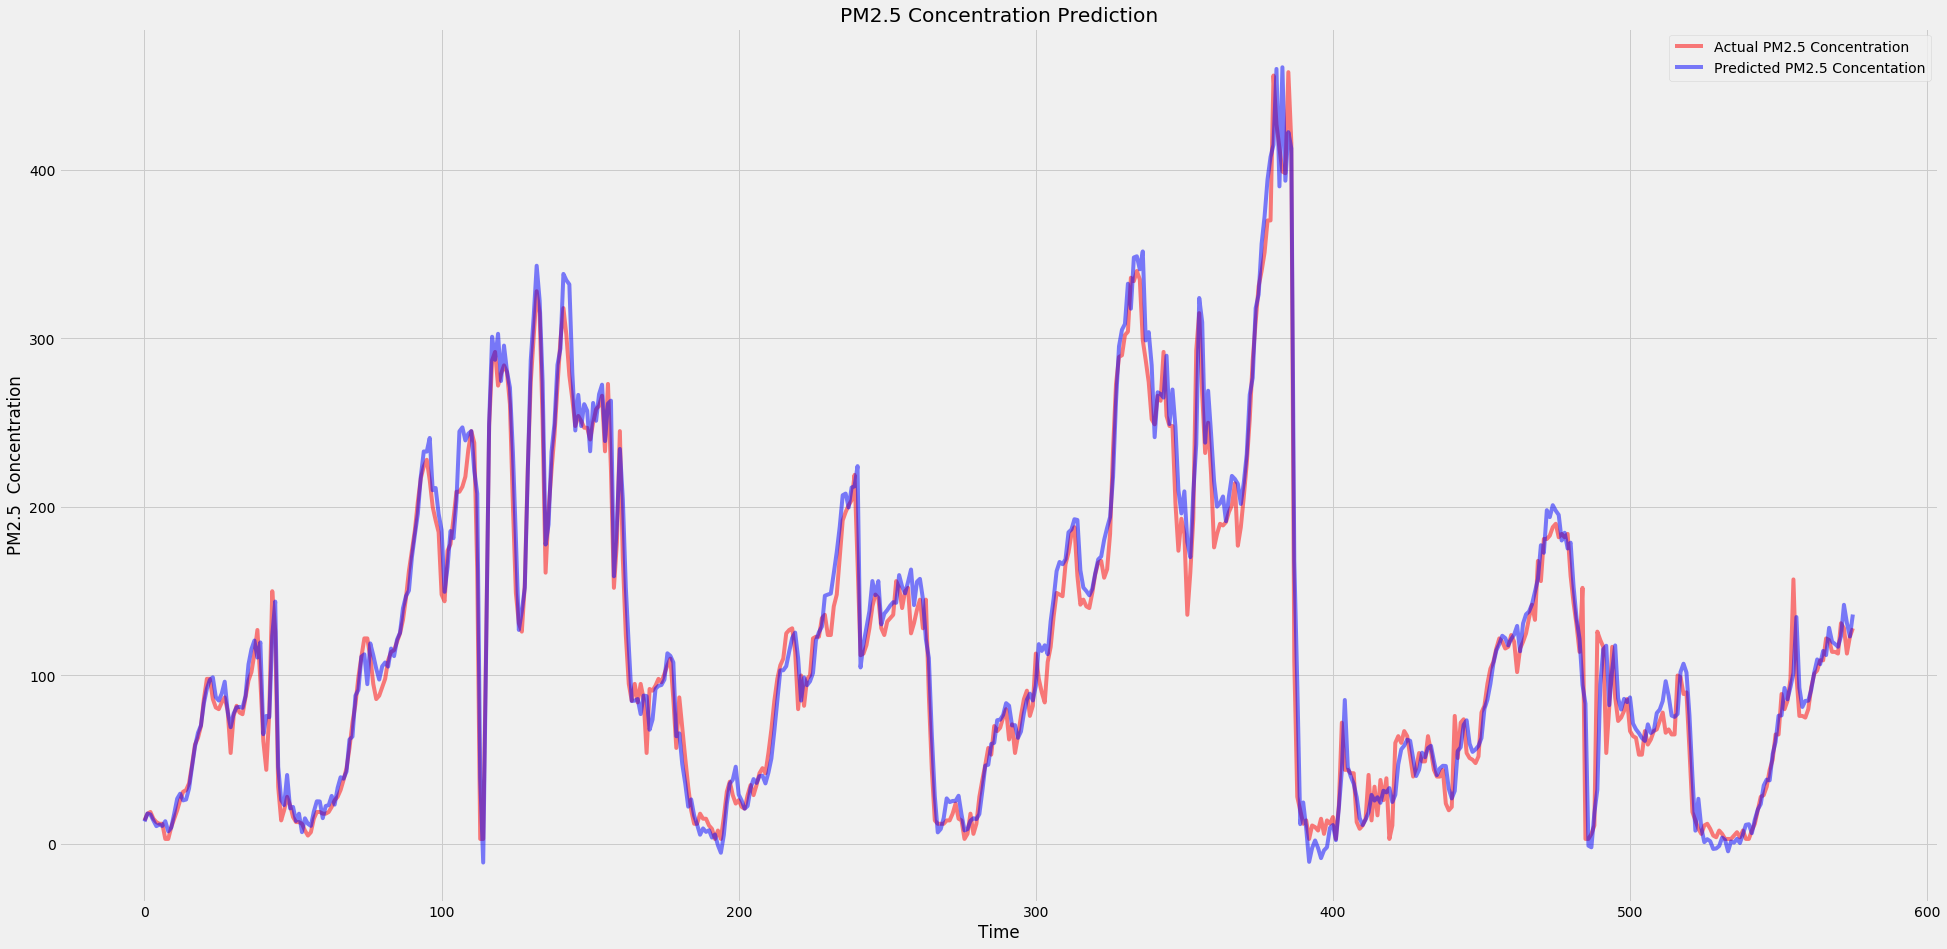

16.755857873276085

In [374]:
plot_predictions(y_train_origin,y_train_pred_origin)
return_rmse(y_train_origin,y_train_pred_origin)


(76, 24, 12)

In [270]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
inputs = dataset[len(dataset)-len(test_set) - seq_len:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(seq_len,test_size+seq_len):
    X_test.append(inputs[i-seq_len:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],12))
predicted_PM25 = LSTM_GRU_reg.predict(X_test)
predicted_PM25 = sc.inverse_transform(predicted_PM25[0])


ValueError: non-broadcastable output operand with shape (1984,1) doesn't match the broadcast shape (1984,12)

In [272]:
predicted_PM25.shape

(576, 1)